In [20]:
import cobra
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import networkx as nx

# Plot setup

In [21]:
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('colorblind')

#  iCH360 Basic statistics

In [22]:
ich360=cobra.io.read_sbml_model('../../Model/iCH360/Escherichia_coli_iCH360.xml')
ich360_graph=nx.read_gml('../../Knowledge_Graph/ich360_graph.gml')

In [23]:
metabolic_reactions=[r for r in ich360.reactions if r not in ich360.boundary]
genes=ich360.genes
all_metabolites=ich360.metabolites
unique_metabolites=set([re.sub('_[epc]$','',m.id) for m in ich360.metabolites])



#Note: we count all genes in the graph, which includes 3 putative genes that were not included in the COBRA model gprs.
all_genes=[node for node in ich360_graph.nodes() if ich360_graph.nodes[node]['type']=='gene']

print(f'Number of metabolic reactions: {len(metabolic_reactions)}')
print(f'Number of genes: {len(all_genes)}')
print(f'Number of metabolites: {len(all_metabolites)}')
print(f'Number of unique metabolites: {len(unique_metabolites)}')


Number of metabolic reactions: 323
Number of genes: 360
Number of metabolites: 304
Number of unique metabolites: 254


# Comparison with ECC,ECC2, and iML1515

In [24]:
#Core model
core=cobra.io.read_sbml_model('../data/metabolic_models/ecoli_core/e_coli_core.xml') 

#iML1515
iml1515=cobra.io.read_sbml_model('../data/metabolic_models/iML1515/iML1515.xml') 
iml1515.remove_reactions([iml1515.reactions.BIOMASS_Ec_iML1515_WT_75p37M]) #this is an alternative biomass reaction

#ECC2
ecc2=cobra.io.read_sbml_model('../data/metabolic_models/ecc2/ecc2_standardized.xml')

models=[core,ich360,ecc2,iml1515]
model_names=['ECC','iCH360','ECC2','iML1515']
biomass_rxns_id={'core':'BIOMASS_Ecoli_core_w_GAM','ich360':'Biomass','iml1515':'BIOMASS_Ec_iML1515_core_75p37M','ecc2':'Ec_biomass_iJO1366_core_53p95M'}

# Model Size

In [25]:
basic_stats=pd.DataFrame(index=model_names,
                    columns=['model','reactions','metabolites','genes'])
basic_stats['model']=model_names
basic_stats['reactions']=[len([r for r in model.reactions if r not in model.boundary]) for model in models]
basic_stats['metabolites']=[len(model.metabolites) for model in models]

basic_stats['genes']=[len(model.genes) for model in models]
basic_stats.loc['iCH360','genes']=len(all_genes)

basic_stats


,model,reactions,metabolites,genes
ECC,ECC,75,72,137
iCH360,iCH360,323,304,360
ECC2,ECC2,467,486,0
iML1515,iML1515,2374,1877,1516


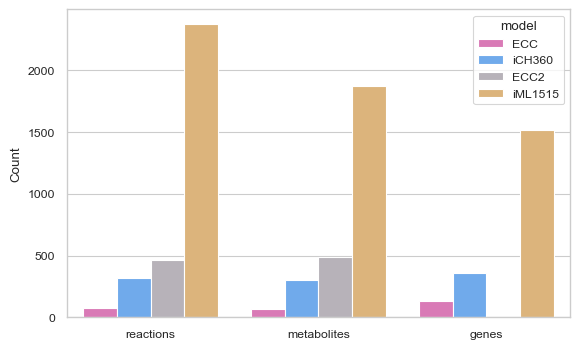

In [26]:
#Plotting model size comparison with seaborne
basic_stats_long=pd.melt(basic_stats,id_vars='model',var_name='statistic',value_name='count')
ecc_color='#e96abaff'
iCH360_color='#5ba9ffff'
ecc2_color='#b7b1baff'
iml1515_color='#ecb66cff'
fig,ax=plt.subplots(figsize=(6.5,4))
sns.barplot(data=basic_stats_long,x='statistic',y='count',hue='model',ax=ax,palette=[ecc_color,iCH360_color,ecc2_color,iml1515_color])
ax.set_xlabel('')
ax.set_ylabel('Count')

plt.show()

for extention in ['png','pdf','svg']:
    fig.savefig(f'../figures/model_size_comparison.{extention}',dpi=300,bbox_inches='tight')


# Growth on different substrates

In [27]:
%%capture
#Define carbon sources
carbon_sources=['glc__D','fru','lac__D','ac','pyr' ,'glyc','rib__D','xyl__D','succ','fum','akg']
carbon_sources_names=['Glucose','Fructose','Lactate','Acetate','Pyruvate','Glycerol','Ribose','Xylose','Succinate','Fumarate','AKG']
carbon_soucre_id_name_map={cs:cs_name for cs,cs_name in zip(carbon_sources,carbon_sources_names)}
exchange_fluxes=['EX_'+c_source+'_e' for c_source in carbon_sources]
conditions=['aerobic','anaerobic']
carbon_influx=10

#Compute results
results=[]#pd.DataFrame(columns=['model','carbon_source','condition','growth_rate'])
for i,model in enumerate(models):
    for cs in carbon_sources:
        for condition in conditions:
            with model:
                exchange_rxn='EX_'+cs+'_e'
                if exchange_rxn not in model.reactions:
                    continue
                # Block default glucose exchange
                model.reactions.EX_glc__D_e.lower_bound=0
                #Block oxygen if anaerobic
                if condition=='anaerobic':
                    model.reactions.EX_o2_e.lower_bound=0
                #Set carbon source uptake and solve
                model.reactions.get_by_id(exchange_rxn).lower_bound=-carbon_influx
                sol=model.optimize()
                #Fill in result table
                new_row={'model':[model_names[i]],
                        'carbon_source':[carbon_soucre_id_name_map[cs]],
                        'condition':[condition],
                        'biomass_flux':[sol.objective_value if sol.status=='optimal' else 0]
                        }
                results.append(new_row)
results_df=pd.concat([pd.DataFrame.from_dict(r) for r in results])     


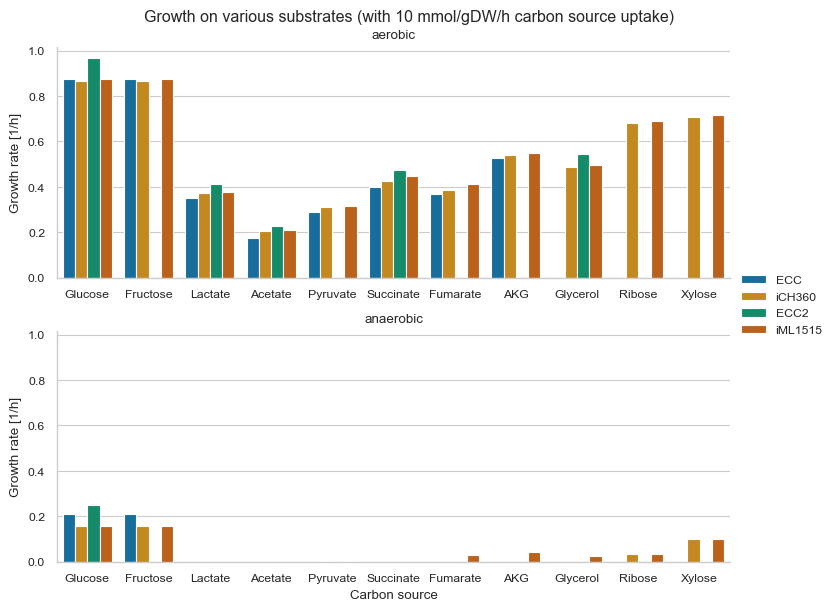

In [28]:
'''
Plot results in seaborne, faceting by condition
'''
plot=sns.FacetGrid(data=results_df,
                   row='condition',
                   sharey=True,
                   sharex=False,
                   col_order=['aerobic','anaerobic'],
                   height=3,
                   aspect=2.5,
                   legend_out=True
                   )

plot.map_dataframe(sns.barplot,x='carbon_source',
                   y='biomass_flux',
                   hue='model',
                   palette='colorblind')
plot.add_legend()
plot.set_titles('{row_name}')
plot.set_axis_labels('Carbon source','Growth rate [1/h]')
plot.fig.suptitle('Growth on various substrates (with 10 mmol/gDW/h carbon source uptake)',y=1.01)
plt.show()

for extention in ['png','pdf','svg']:
    plot.savefig(f'../figures/carbon_source_growth_comparison.{extention}',dpi=300,bbox_inches='tight')

Now let's only plot iCH360 and iML1515, as this is the main comparison we want to focus on 

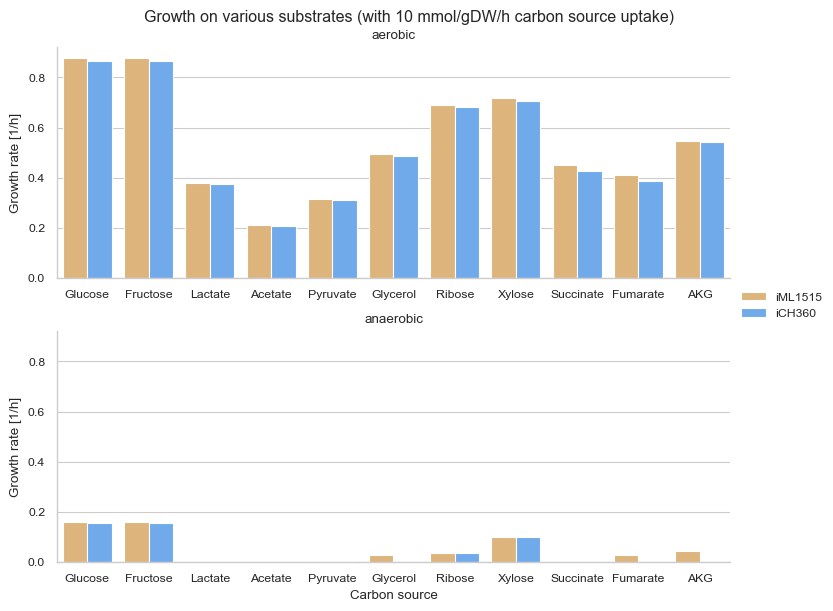

In [29]:
plot=sns.FacetGrid(data=results_df.query("model in ['iML1515','iCH360']"),
                   row='condition',
                   sharey=True,
                   sharex=False,
                   col_order=['aerobic','anaerobic'],
                   height=3,
                   aspect=2.5,
                   legend_out=True
                   )

plot.map_dataframe(sns.barplot,x='carbon_source',
                   y='biomass_flux',
                   hue='model',
                   hue_order=['iML1515','iCH360'],
                   palette=[iml1515_color,iCH360_color])
plot.add_legend()
plot.set_titles('{row_name}')
plot.set_axis_labels('Carbon source','Growth rate [1/h]')
plot.fig.suptitle('Growth on various substrates (with 10 mmol/gDW/h carbon source uptake)',y=1.01)
plt.show()

for extention in ['png','pdf','svg']:
    plot.savefig(f'../figures/carbon_source_growth_comparison_iCH360_iML1515.{extention}',dpi=300,bbox_inches='tight')